# Open Malaria Predictive Model Report
#### Ángela López del Río

Taking profit of a competition from the Open Source Malaria project (https://github.com/OpenSourceMalaria/OSM_To_Do_List/issues/421), which provides a collection of molecules and their activity against the malaria parasite's ion pump, PfATP4, a machine learning-based QSAR model has been developed. This model aims to predict which molecules will block this target. 

In [17]:
%run 'malaria_functions.ipynb'

from __future__ import absolute_import, division, print_function, unicode_literals
import os
import sys
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

Firstly, the dataset of active and inactive compounds for the target PfATP4 provided in the OSM Competition is loaded. 

In [2]:
#Loading data with compounds IDs, SMILES and information about their activity
osm_list = reading_csv()
osm_cleaned = data_preproc(osm_list)

Number of instances of each level of ION_ACTIVITY 
 0.0    395
1.0     55
0.5      5
Name: ION_ACTIVITY, dtype: int64


Since the Potency vs Parasite (EC50) data of most of the molecules is provided, this value is plotted against the PfATP4 activity label to check if there is a correlation between the whole cell assay results and the activity against this specific ion. 

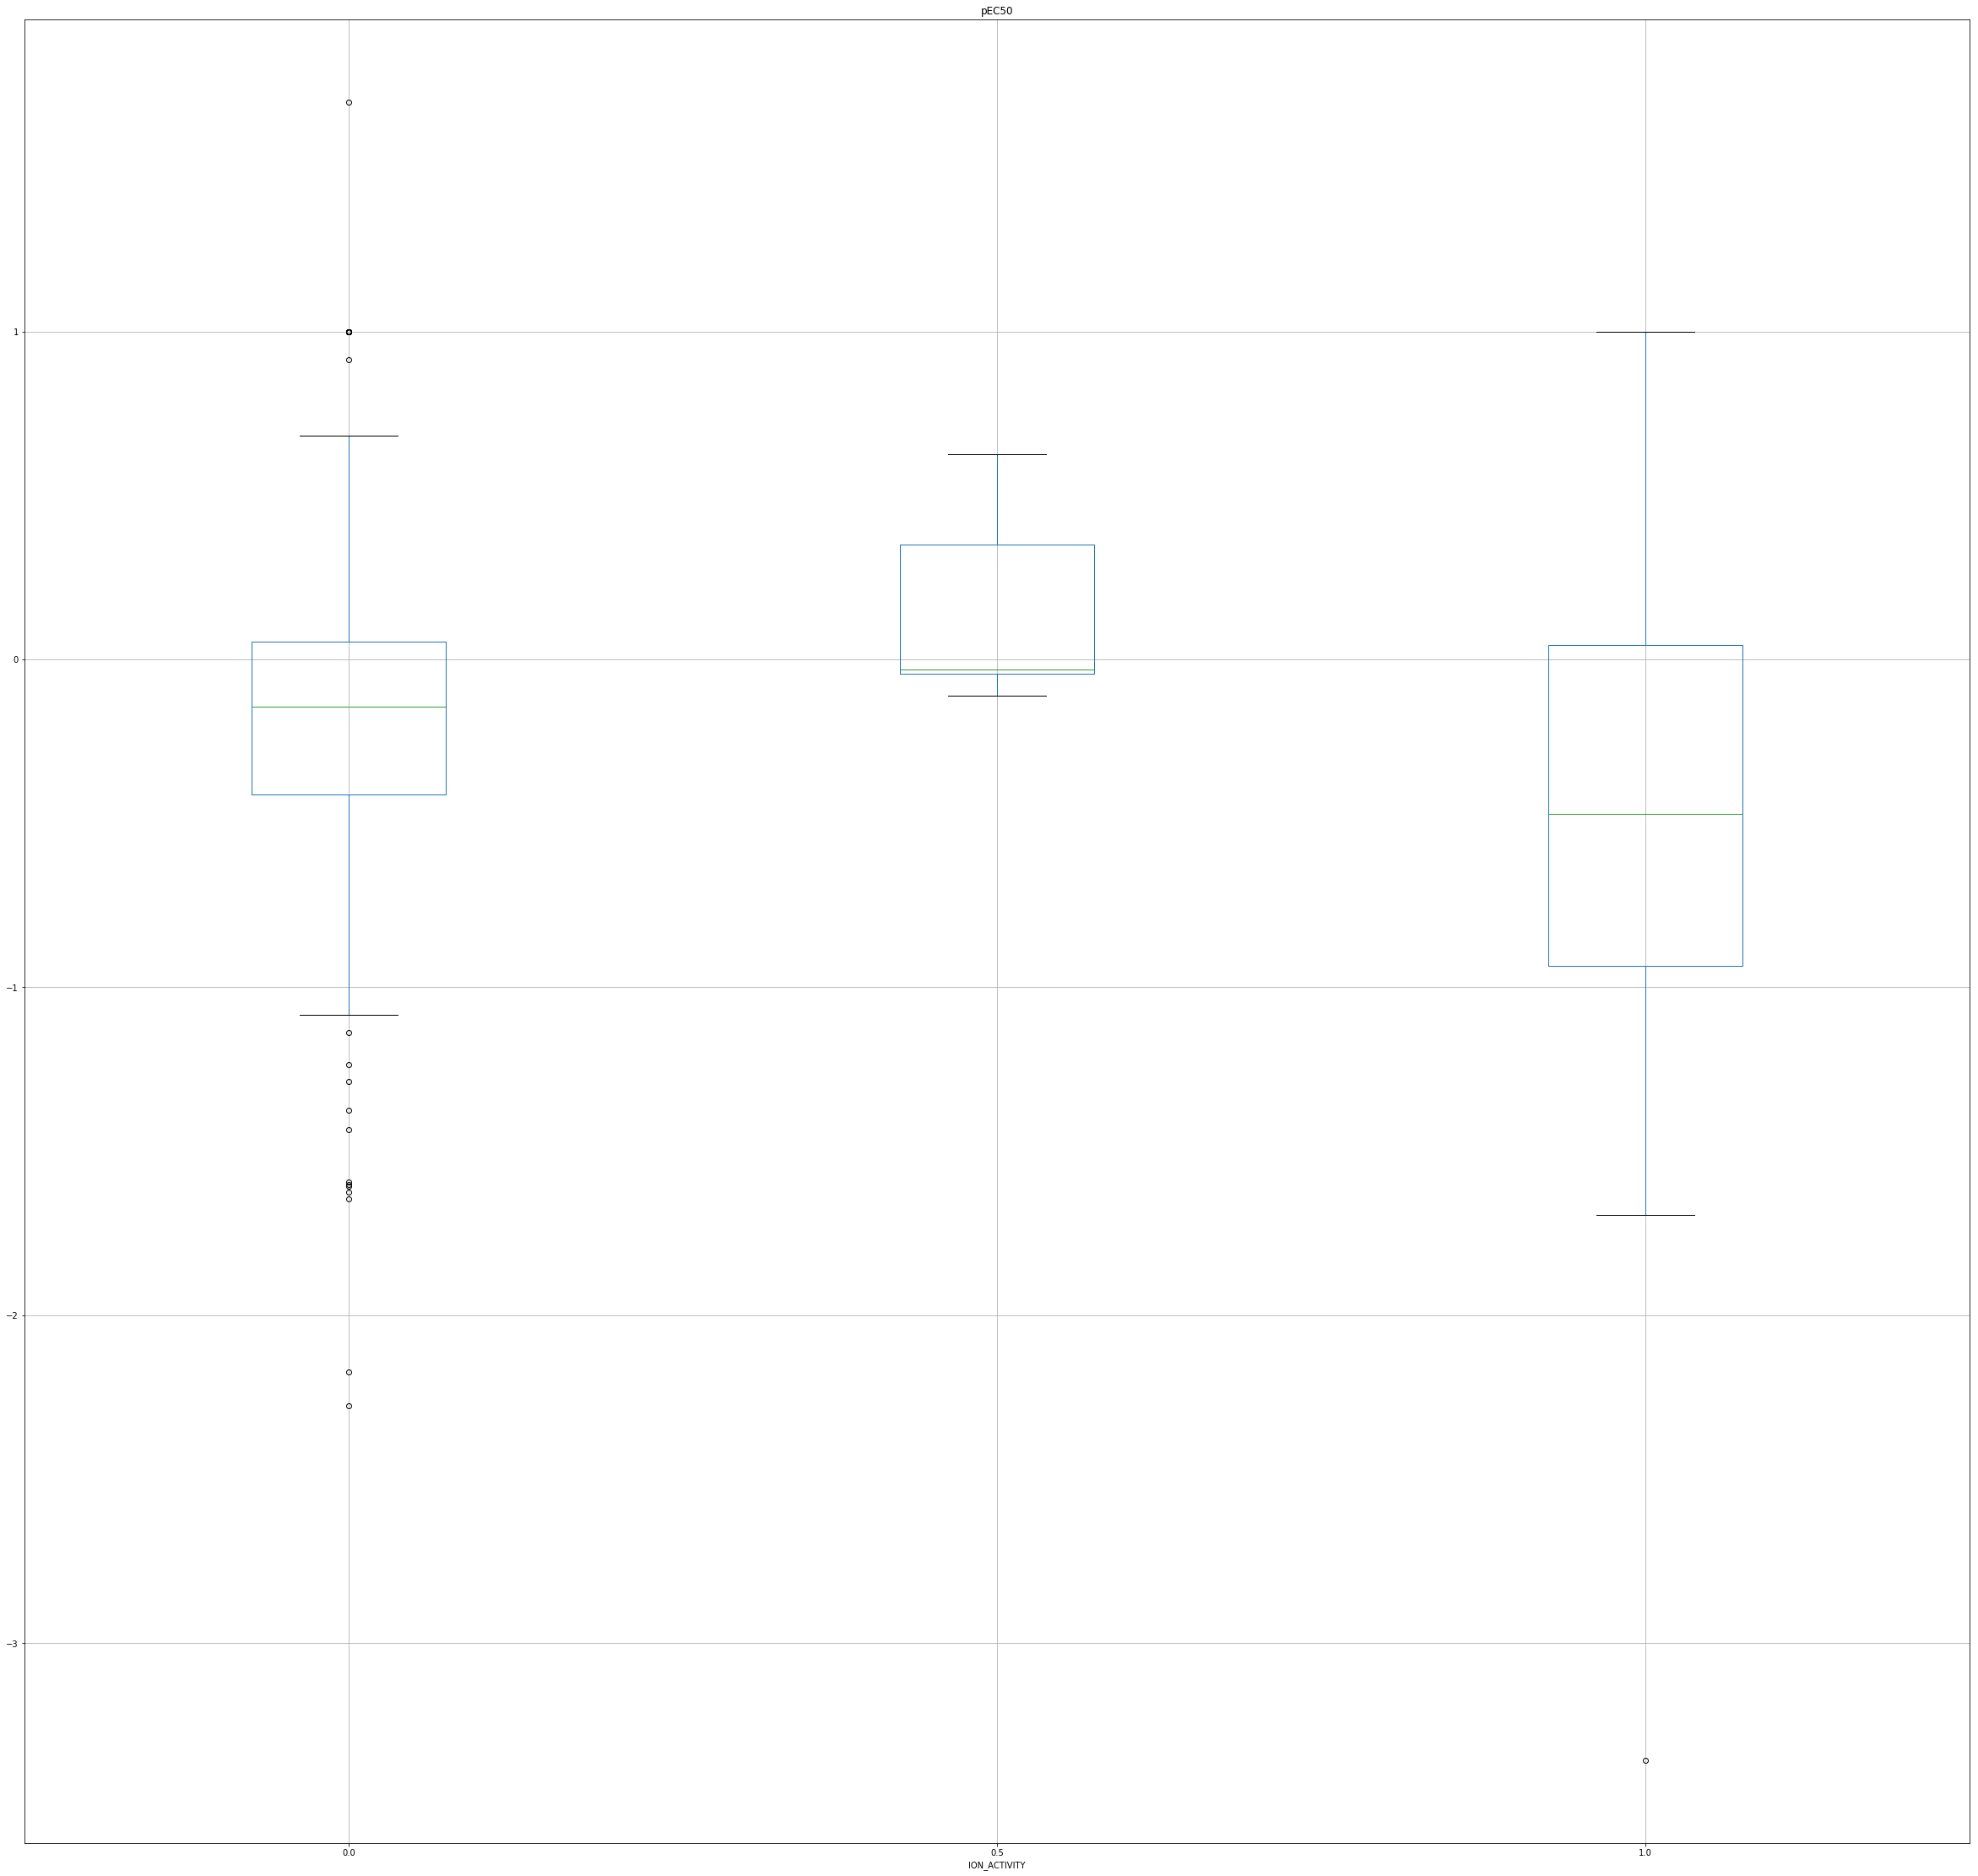

In [3]:
# Boxplotting to check how pEC50 correlates to ION_ACTIVITY indexes
fig = osm_cleaned.boxplot('pEC50', by='ION_ACTIVITY')
fig.get_figure().suptitle("")
plt.show()

As it can be seen in the plot, the followed behaviour is not as expected: the whole cell assay response doesn't seem to be related to the ion activity label. 

However, if we separate the Series 4 compounds (those in whose design and synthesis is currently focused the OSM project), these two values correlate as expected:

Number of instances of each level of ION_ACTIVITY 
 1.0    23
0.0    17
0.5     4
Name: ION_ACTIVITY, dtype: int64


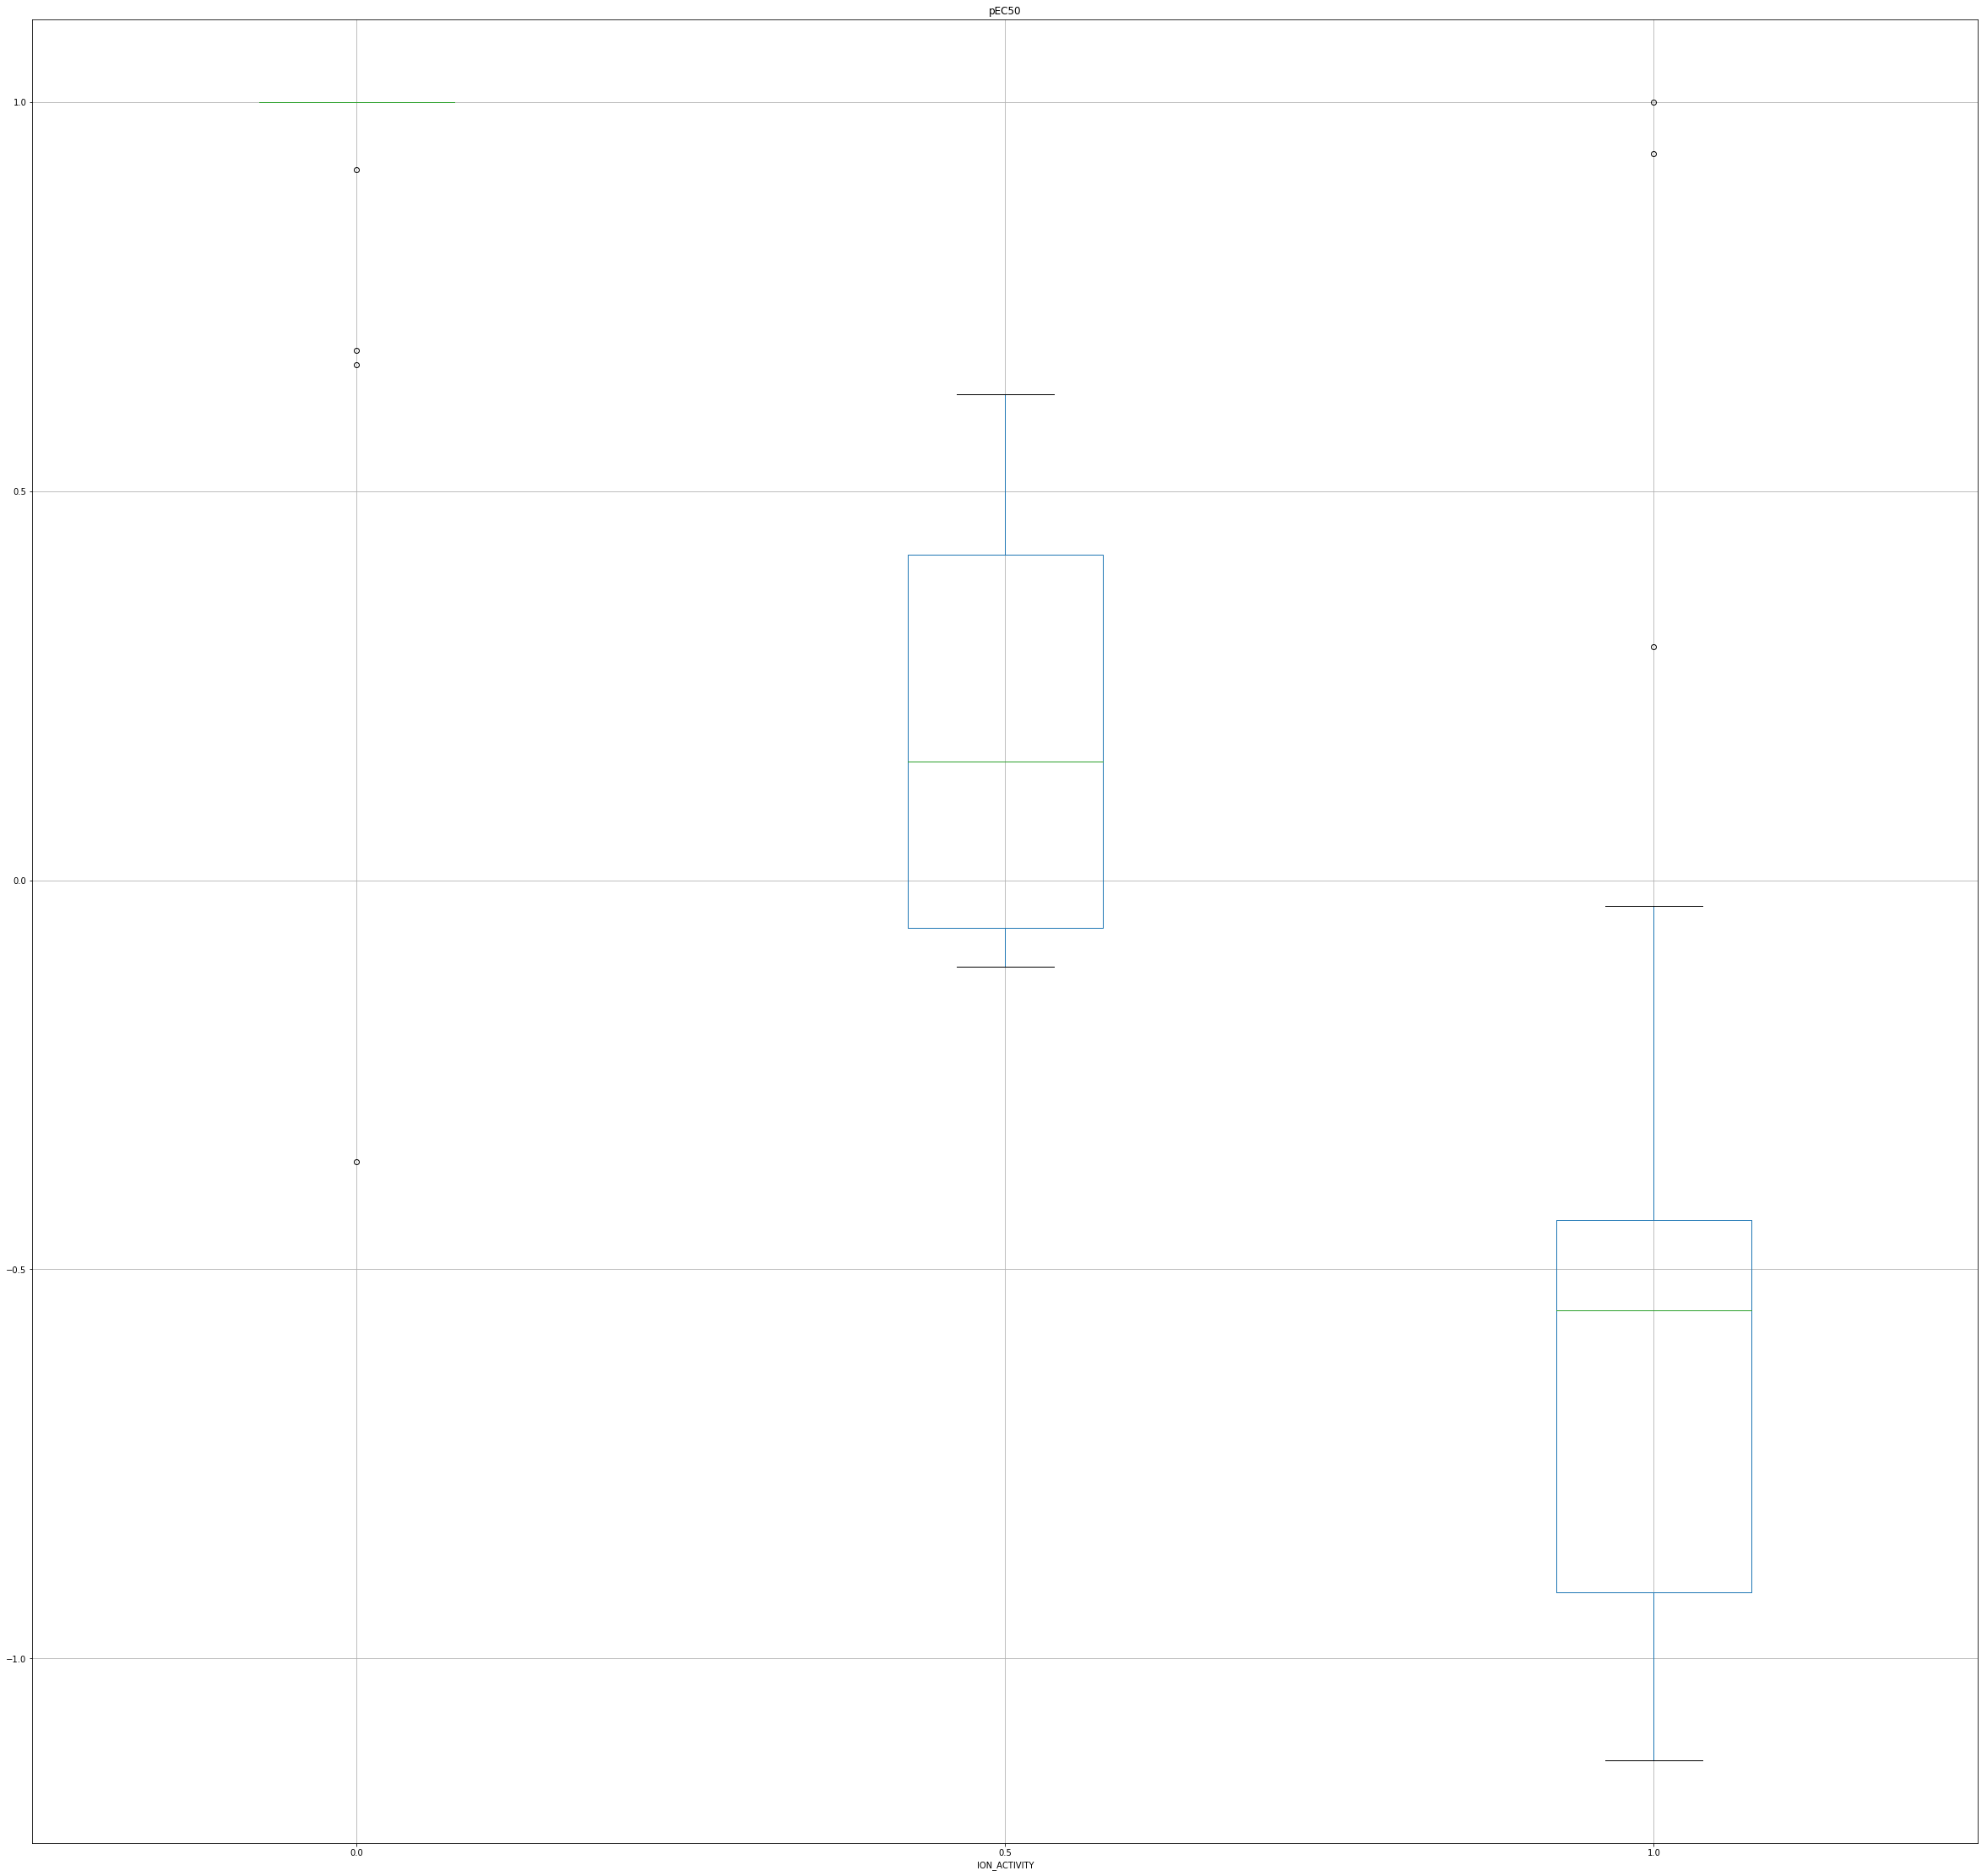

In [4]:
# Separating Series 4 compounds
osm_series4 = series4_cmp(osm_cleaned)

# Boxplotting to check how pEC50 correlates to ION_ACTIVITY indexes only taking into account Series 4 indexes
fig = osm_series4.boxplot('pEC50', by='ION_ACTIVITY')
fig.get_figure().suptitle("")
plt.show()

Pybel and RDkit descriptors of OSM molecules are computed, resulting in 215 descriptors for each compound.

In [10]:
#Getting RDkit descriptors
osm_rdkit = rdkit_desc(osm_cleaned)
#Getting Pybel descriptors
osm_pyb = pybel_desc(osm_cleaned)
#merging descriptors
pyb_rdk = merge_dfs(osm_pyb, osm_rdkit)

pyb_rdk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455 entries, 0 to 454
Columns: 215 entries, HBA1 to fr_urea
dtypes: float64(108), int64(104), object(3)
memory usage: 767.8+ KB


The provided dataset contains ion activity information of 395 actives and 55 inactives molecules. Additionally, 5 molecules appear to be partially active, but since such a small number of samples has no statistically power, it will be removed from further steps.

In [19]:
#Converting dataframe to ndarray
npdesc, nplab = df_to_ndarrays(pyb_rdk)
# Scaling data
npdesc = preprocessing.scale(npdesc)

Data is randomly divided in training set (70%) and test set (30%).

In [20]:
x_train_s, x_test, y_train_s, y_test = splitting_data(npdesc, nplab, 0.3)
print("Training dataset shape {}".format(Counter(y_train_s)))
print("Test dataset shape {}".format(Counter(y_test)))

Training dataset shape Counter({0.0: 281, 1.0: 34})
Test dataset shape Counter({0.0: 114, 1.0: 21})


At this point, different classification models were tuned, trained and evaluated. The performance of different classification algorithms (Logistic Regression Model, Support Vector Machine, Random Forests, K-Nearest Neighbours, Extreme Gradient Boosting) was assessed, with and without applying a previous feature selection based on the importance of the variables and with and without applying an oversampling method to cover the imbalance between the inactives and actives. 

The preliminary first results showed that the **Extreme Gradient Boosting**\* (XGBoost) presented a best performance, so the final model was built and exhaustively tuned using it. This algorithm dominates structured or tabular datasets on classification and regression predictive modeling problems, and it is the go-to method for competition winners on the Kaggle competitive data science platform.

Gradient boosting is basically about "boosting" many weak predictive models into a strong one, in the form of ensemble of weak models. To build the strong model, we need to find a good way to "combine" weak models. In the most popular boosting algorithm, weak models are trained in an adaptive way: a weak model is trained using data samples drawn according to some weight distribution; then, the weight of samples that are misclassified by the model is increased and the weight of samples that are classified correctly is decreased. The next weak model is trained using samples drawn according to the updated weight distribution.

In this way, the algorithm always trains models using data samples that are "difficult" to learn in previous rounds, which results an ensemble of models that are good at learning different "parts" of training data.

\* <sub>Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. https://doi.org/10.1145/2939672.2939785</sub>

In [338]:
optim_model = xgboost_tuning(x_train_s, y_train_s);

/Users/angela/virtualenvs/malaria/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.86857, std: 0.04982, params: {u'max_depth': 3, u'min_child_weight': 1}, mean: 0.83821, std: 0.10305, params: {u'max_depth': 3, u'min_child_weight': 3}, mean: 0.82549, std: 0.09078, params: {u'max_depth': 3, u'min_child_weight': 5}, mean: 0.89394, std: 0.02957, params: {u'max_depth': 5, u'min_child_weight': 1}, mean: 0.83711, std: 0.10260, params: {u'max_depth': 5, u'min_child_weight': 3}, mean: 0.82812, std: 0.09415, params: {u'max_depth': 5, u'min_child_weight': 5}, mean: 0.88721, std: 0.01406, params: {u'max_depth': 7, u'min_child_weight': 1}, mean: 0.83711, std: 0.10260, params: {u'max_depth': 7, u'min_child_weight': 3}, mean: 0.82812, std: 0.09415, params: {u'max_depth': 7, u'min_child_weight': 5}, mean: 0.88721, std: 0.01406, params: {u'max_depth': 9, u'min_child_weight': 1}, mean: 0.83711, std: 0.10260, params: {u'max_depth': 9, u'min_child_weight': 3}, mean: 0.82812, std: 0.09415, params: {u'max_depth': 9, u'min_child_weight': 5}] {u'max_depth': 5, u'min_child_weight': 

/Users/angela/virtualenvs/malaria/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.89394, std: 0.02957, params: {u'gamma': 0.0}, mean: 0.88791, std: 0.01990, params: {u'gamma': 0.1}, mean: 0.89613, std: 0.02278, params: {u'gamma': 0.2}, mean: 0.88825, std: 0.01446, params: {u'gamma': 0.3}, mean: 0.88396, std: 0.02309, params: {u'gamma': 0.4}] {u'gamma': 0.2} 0.896128714644


/Users/angela/virtualenvs/malaria/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.87271, std: 0.03473, params: {u'subsample': 0.6, u'colsample_bytree': 0.6}, mean: 0.89003, std: 0.03241, params: {u'subsample': 0.7, u'colsample_bytree': 0.6}, mean: 0.88774, std: 0.02665, params: {u'subsample': 0.8, u'colsample_bytree': 0.6}, mean: 0.87591, std: 0.04539, params: {u'subsample': 0.9, u'colsample_bytree': 0.6}, mean: 0.87674, std: 0.04067, params: {u'subsample': 0.6, u'colsample_bytree': 0.7}, mean: 0.87669, std: 0.04870, params: {u'subsample': 0.7, u'colsample_bytree': 0.7}, mean: 0.87923, std: 0.03392, params: {u'subsample': 0.8, u'colsample_bytree': 0.7}, mean: 0.87922, std: 0.04459, params: {u'subsample': 0.9, u'colsample_bytree': 0.7}, mean: 0.87690, std: 0.03694, params: {u'subsample': 0.6, u'colsample_bytree': 0.8}, mean: 0.87792, std: 0.04472, params: {u'subsample': 0.7, u'colsample_bytree': 0.8}, mean: 0.89236, std: 0.02442, params: {u'subsample': 0.8, u'colsample_bytree': 0.8}, mean: 0.87538, std: 0.04270, params: {u'subsample': 0.9, u'colsample_bytree

/Users/angela/virtualenvs/malaria/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.87682, std: 0.05468, params: {u'subsample': 0.75, u'colsample_bytree': 0.75}, mean: 0.88374, std: 0.02390, params: {u'subsample': 0.8, u'colsample_bytree': 0.75}, mean: 0.87347, std: 0.04924, params: {u'subsample': 0.85, u'colsample_bytree': 0.75}, mean: 0.87527, std: 0.03811, params: {u'subsample': 0.9, u'colsample_bytree': 0.75}, mean: 0.87494, std: 0.04645, params: {u'subsample': 0.75, u'colsample_bytree': 0.8}, mean: 0.89236, std: 0.02442, params: {u'subsample': 0.8, u'colsample_bytree': 0.8}, mean: 0.87607, std: 0.03262, params: {u'subsample': 0.85, u'colsample_bytree': 0.8}, mean: 0.87538, std: 0.04270, params: {u'subsample': 0.9, u'colsample_bytree': 0.8}, mean: 0.87861, std: 0.03686, params: {u'subsample': 0.75, u'colsample_bytree': 0.85}, mean: 0.87769, std: 0.04905, params: {u'subsample': 0.8, u'colsample_bytree': 0.85}, mean: 0.87501, std: 0.03839, params: {u'subsample': 0.85, u'colsample_bytree': 0.85}, mean: 0.86971, std: 0.04168, params: {u'subsample': 0.9, u'col

/Users/angela/virtualenvs/malaria/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.89236, std: 0.02442, params: {u'reg_alpha': 1e-05}, mean: 0.88211, std: 0.03421, params: {u'reg_alpha': 0.01}, mean: 0.88798, std: 0.02462, params: {u'reg_alpha': 0.1}, mean: 0.88622, std: 0.02256, params: {u'reg_alpha': 1}, mean: 0.50000, std: 0.00000, params: {u'reg_alpha': 100}] {u'reg_alpha': 1e-05} 0.892355889724
[mean: 0.88912, std: 0.02473, params: {u'n_estimators': 100, u'learning_rate': 0.0001}, mean: 0.88585, std: 0.02643, params: {u'n_estimators': 200, u'learning_rate': 0.0001}, mean: 0.88562, std: 0.02849, params: {u'n_estimators': 300, u'learning_rate': 0.0001}, mean: 0.88562, std: 0.02849, params: {u'n_estimators': 400, u'learning_rate': 0.0001}, mean: 0.88709, std: 0.02283, params: {u'n_estimators': 500, u'learning_rate': 0.0001}, mean: 0.88609, std: 0.02585, params: {u'n_estimators': 100, u'learning_rate': 0.001}, mean: 0.88296, std: 0.02589, params: {u'n_estimators': 200, u'learning_rate': 0.001}, mean: 0.88198, std: 0.02933, params: {u'n_estimators': 300, u'l

/Users/angela/virtualenvs/malaria/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [339]:
optim_model

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.2, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective=u'binary:logistic', reg_alpha=1e-05, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)

In [21]:
optim_model =XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.2, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective=u'binary:logistic', reg_alpha=1e-05, reg_lambda=1,
       scale_pos_weight=281/34, seed=27, silent=True, subsample=0.8)

The classification model is built from the set defined as training, with the optimal parameters obtained from tuning. 
Down below, the model report is shown, along with its performance on the set of compounds defined as test set. 


Model Report
Accuracy (train set): 1
AUC Score (Train): 1.000000
Accuracy (test set): 0.8963
AUC Score (Test): 0.860067
Confusion matrix:
[[111   3]
 [ 11  10]]
Detailed classification report:
             precision    recall  f1-score   support

        0.0       0.91      0.97      0.94       114
        1.0       0.77      0.48      0.59        21

avg / total       0.89      0.90      0.89       135



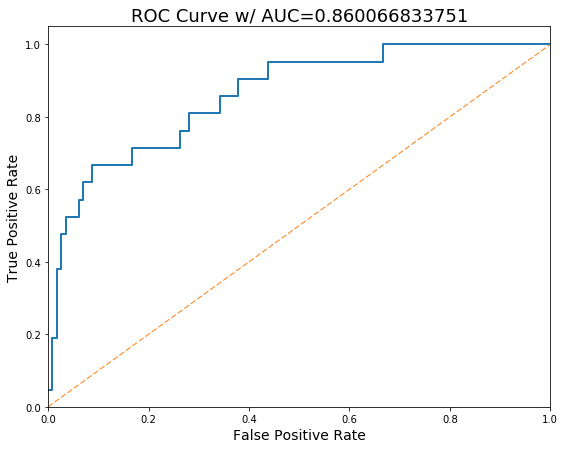

In [34]:
#building the predictive model
cv_folds=5 
early_stopping_rounds=50
alg = optim_model
# loading numpy array into dMatrix
xgb_train = xgb.DMatrix( x_train_s, label=y_train_s)
xgb_test = xgb.DMatrix( x_test, label=y_test)
    
#Train cross validation
xgb_param = alg.get_xgb_params()
cvresult = xgb.cv(xgb_param, xgb_train, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                      metrics = ['logloss'], early_stopping_rounds=early_stopping_rounds)
alg.set_params(n_estimators=cvresult.shape[0])
    
#Fit the algorithm on the data
alg.fit(x_train_s, y_train_s, eval_metric='auc')
#alg.fit(x_train, y_train, eval_metric='logloss')
    
#Predict in training set
y_trpred = alg.predict(x_train_s)
y_trpredprob = alg.predict_proba(x_train_s)[:,1]
    
#Predict in test set
y_pred = alg.predict(x_test)
y_predprob = alg.predict_proba(x_test)[:,1]
    
#Print model report:
print ("\nModel Report")
    
print ("Accuracy (train set): %.4g" % metrics.accuracy_score(y_train_s, y_trpred))
print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_train_s, y_trpredprob))
    
print ("Accuracy (test set): %.4g" % metrics.accuracy_score(y_test, y_pred))
print ("AUC Score (Test): %f" % metrics.roc_auc_score(y_test, y_predprob))    
    
#parte añadida que puede petar
################################################################################
print("Confusion matrix:")
print (metrics.confusion_matrix(y_test, y_pred))
print("Detailed classification report:")
print (metrics.classification_report(y_test, y_pred))
                    
# Computing ROC curve
fpr, tpr, _ = metrics.roc_curve(y_test, y_predprob)

# df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
# x = ggplot(df, aes(x='fpr', y='tpr')) + \
#     geom_line() + \
#     geom_abline(linetype='dashed') + \
#     scale_x_continuous(limits=(0,1)) + \
#     scale_y_continuous(limits=(0,1)) + \
#     xlab('FPR') + \
#     ylab('TPR') + \
#     theme_gray() + \
#     ggtitle("ROC Curve w/ AUC=%s" % str(metrics.auc(fpr,tpr)))

plt.figure(figsize=(9,7))
lw = 2
plt.plot(fpr, tpr, lw=lw)
#         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
            
plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
#plt.title('Receiver operating characteristic example')
plt.title("ROC Curve w/ AUC=%s" % str(metrics.auc(fpr,tpr)), fontsize = 18)
#plt.legend(loc="lower right")
plt.savefig('roc_BUENA2.eps')
plt.show()


#ggsave(x, filename="malaria_roc.png", dpi=600 )
#print(x)

As it is shown in the previous block, both accuracy and AUC curve show the predictive power of this model.

The importance of the descriptors in the xgboost model was calculated, in order to gain insight in the performance of the classificator. 

In [31]:
plt.savefig('roc_BUENA.png')

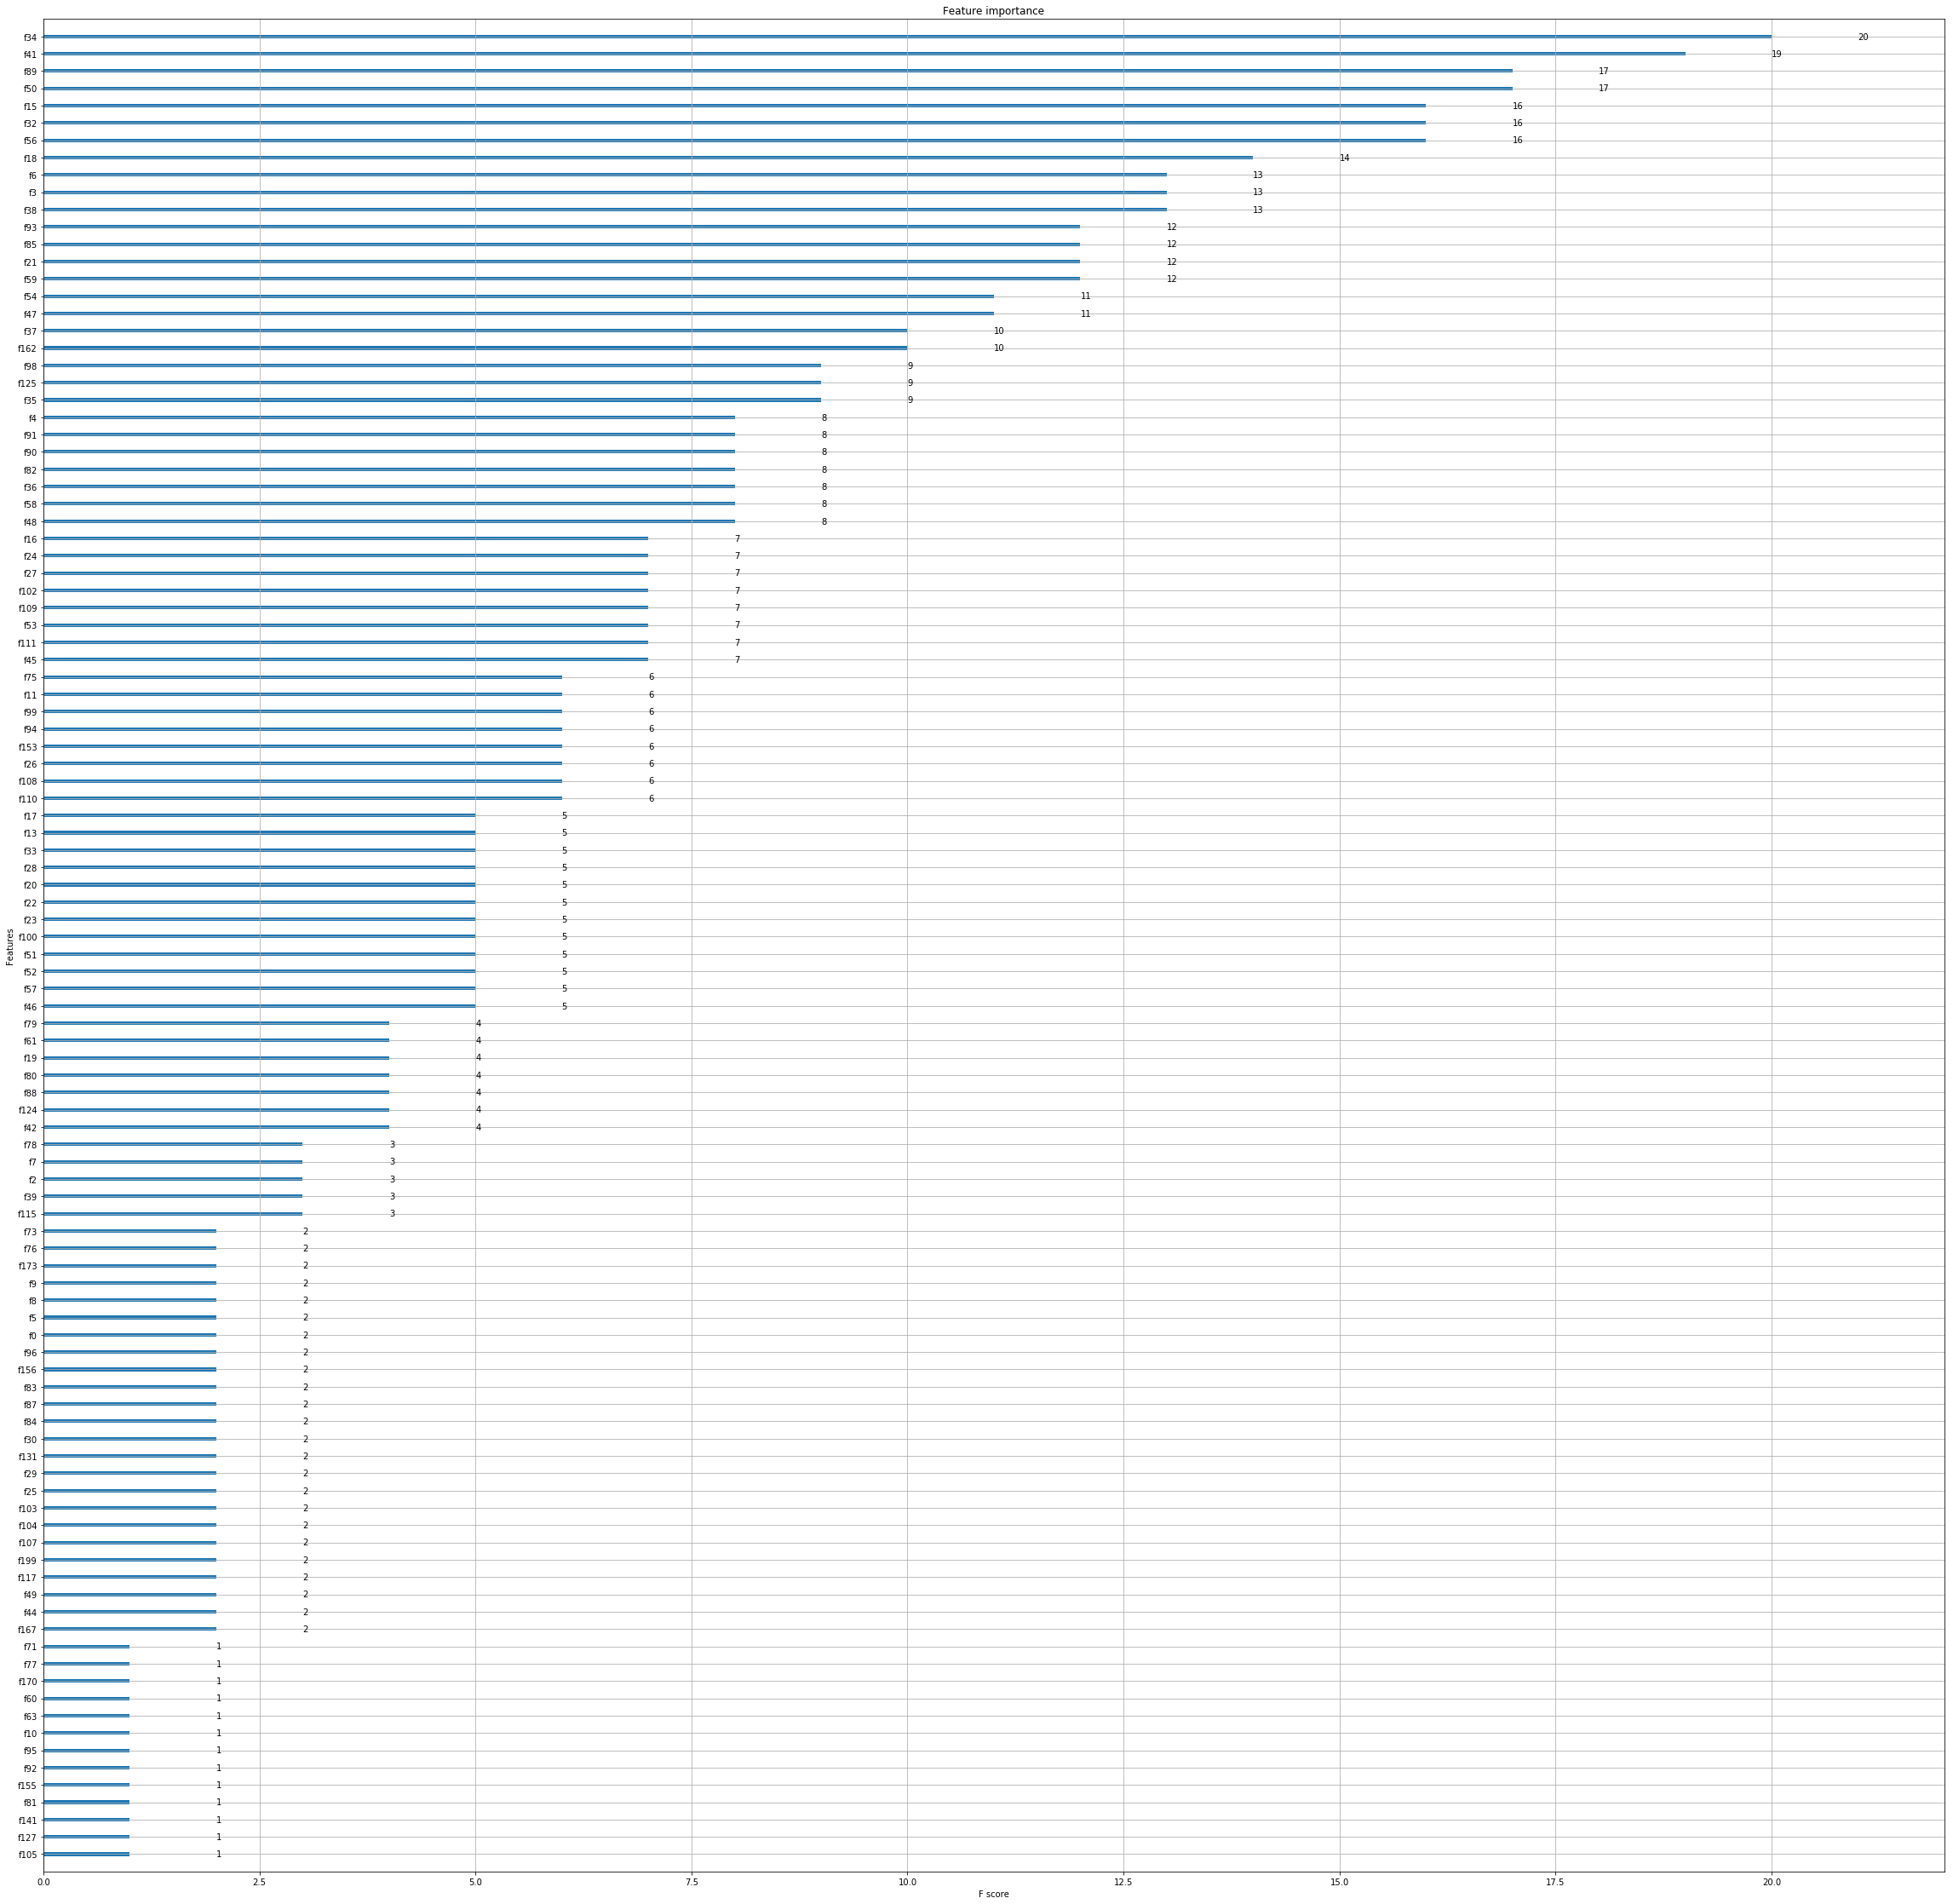

In [342]:
# plot feature importance
plot_importance(alg)
pyplot.show()

In [12]:
#Creating a map of variables to identify the most relevant ones
#Names of the variables
vars = pyb_rdk.drop(['ION_ACTIVITY', 'SMILES', 'MOLECULES'], axis=1).columns
mapping_vars = {}
xgnames = [j + str(i) for i, j in zip(range(len(vars)), ["f"] * len(vars))]
mapping_vars = dict(zip(xgnames, vars))
#Most relevant descriptors
for i in ['f34', 'f41', 'f89', 'f50', 'f15','f32', 'f56', 'f18', 'f6', 'f3', 'f38', 'f93',  'f85', 'f21', 'f59' ]:
    print(mapping_vars[i])

EState_VSA4
FractionCSP3
PEOE_VSA7
MaxAbsEStateIndex
BalabanJ
EState_VSA2
MinEStateIndex
Chi0n
TPSA_x
MP
EState_VSA8
SMR_VSA1
PEOE_VSA3
Chi1n
MolMR


The descriptors shown above are the 15 most relevant features for the classification model constructed.

Taking this into account, we try to fit the model imposing a threshold of importance (this is, allowing only the descriptors over a certain threshold of importance to be variables of the predictive model).

In [13]:
# Fit model using each importance as a threshold
thresholds = np.arange(0.0, 0.030, 0.005)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(alg, threshold=thresh, prefit=True)
    select_X_train = selection.transform(x_train_s)
    # train model
    #selection_model = XGBClassifier()
    selection_model=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.2, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective=u'binary:logistic', reg_alpha=1e-05, reg_lambda=1,
       scale_pos_weight=281/34, seed=27, silent=True, subsample=0.8)
    selection_model.fit(select_X_train, y_train_s)
    # eval model
    select_X_test = selection.transform(x_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    print (metrics.confusion_matrix(y_test, y_pred))

Thresh=0.000, n=211, Accuracy: 89.63%
[[111   3]
 [ 11  10]]
Thresh=0.005, n=64, Accuracy: 89.63%
[[109   5]
 [  9  12]]
Thresh=0.010, n=37, Accuracy: 88.15%
[[109   5]
 [ 11  10]]
Thresh=0.015, n=19, Accuracy: 88.15%
[[107   7]
 [  9  12]]
Thresh=0.020, n=11, Accuracy: 88.89%
[[108   6]
 [  9  12]]
Thresh=0.025, n=7, Accuracy: 85.93%
[[107   7]
 [ 12   9]]


We can check that only includying in the model the 64 (threshold = 0.005) most relevant features, we already obtain the best accuracy of our model, so we re-construct the model only from these features to avoid overfitting.

In [25]:
#Definitive model

#thresh = 0.005
thresh = 0.010
# select features using threshold
selection = SelectFromModel(alg, threshold=thresh, prefit=True)
select_X_train = selection.transform(x_train_s)
# train model
selection_model = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.2, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective=u'binary:logistic', reg_alpha=1e-05, reg_lambda=1,
       scale_pos_weight=281/34, seed=27, silent=True, subsample=0.8)
selection_model.fit(select_X_train, y_train_s)
# eval model
select_X_test = selection.transform(x_test)
y_pred = selection_model.predict(select_X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
print (metrics.confusion_matrix(y_test, y_pred))

Thresh=0.010, n=37, Accuracy: 88.15%
[[109   5]
 [ 11  10]]


## Prediction on the set of marine molecules

Now the predictive model will be apply to predict the activity against malaria of the 27 marine molecules provided.

In [15]:
# Loading marine molecules list
mm_list = pd.read_csv("marine_molecules.csv", index_col=None, decimal=",", na_values="ND")
mm_list

,NUMBER,S,SMI,SEQUENCE,SMILES
0,#1,S,"3,5-dibromo-4-hydroxybenzaldehyde.smi",SXRHGLQCOLNZPT-UHFFFAOYSA-N,O=Cc1cc(Br)c(O)c(Br)c1
1,#2,S,Alcyopterosin-A.smi,AOZZRIFMYYWXLE-UHFFFAOYSA-N,Cc1cc2c(c(C)c1CCCl)CC(C)(C)C2
2,#3,S,Antarcticoside-D.smi,SFEIVGCFQJAPTI-DCOKEWDMSA-N,COC1C(O)COC(OC[C@@H](C)C/C=C/C(C)[C@H]2C[C@@H]...
3,#4,S,Aplicyanin-A.smi,VVONRGQMZKFFRP-UHFFFAOYSA-N,N=C1NCCC(c2c[nH]c3ccc(Br)cc23)N1
4,#5,S,Asterasterol-C.smi,KDUVNRKZGYTTJS-GACDVITBSA-N,CC(C/C=C/[C@@H](C)[C@H]1CC[C@H]2C3=CC(=O)[C@H]...
5,#7,S,Austrodoral.smi,CNTXEQHESHSVFZ-UBHSHLNASA-N,CC1(C)CCC[C@@]2(C)[C@H]1CC[C@@]2(C)C=O
6,#9,S,Caminatal.smi,JXMWXFSVMMJDHJ-IKERNBKFSA-N,CC(=O)O[C@@H]1C[C@@](C)(C=O)[C@H](CCC(=O)c2ccc...
7,#10,S,Dendrillin.smi,APHPHCFXAWJFAA-AOGFDJAGSA-N,CC(=O)OC1OC(OC(C)=O)C2C1CC[C@H](C1(C)CCCC(C)(C...
8,#11,S,Dendrinolide.smi,IMIAJJXGLPJMII-CEXWTWQISA-N,CC(=O)O[C@H]1OC=C2CC[C@H](/C(C)=C3/CCCC3(C)C)C...
9,#12,S,Discorhabdin-B.smi,SVKKMXJIWIOCJC-VOJFVSQTSA-N,O=C1C=C2S[C@H]3C[C@]2(C=C1Br)C1=C(N3)C(=O)c2[n...


As with the OSM dataset, RDKit and Pybel descriptors are obtained.

In [16]:
# Getting RDKit descriptors
descs = [x[0] for x in Chem.Descriptors.descList]
col_r = ['SMILES'] + descs
rddf = pd.DataFrame(columns=col_r, index=mm_list.index.values)
rddf = rddf.fillna(0)
rddf.loc[:, "SMILES"] = mm_list.loc[:, "SMILES"]
mrdk_list = smiles_to_rdkit(rddf.loc[:, "SMILES"])
rddf = rddf.assign(MOLECULES=mrdk_list)
list_descriptors = []
mdc = MolecularDescriptorCalculator(descs)
for index, row in rddf.iterrows():
    results = mdc.CalcDescriptors(row["MOLECULES"])
    descriptors = dict(zip(descs, results))
    descriptors.update({'SMILES': row["SMILES"], 'MOLECULES': row["MOLECULES"]})
    list_descriptors.append(descriptors)

rdkit_df_mm = pd.DataFrame(list_descriptors)
rdkit_df_mm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Columns: 198 entries, BalabanJ to fr_urea
dtypes: float64(92), int64(104), object(2)
memory usage: 41.8+ KB


In [17]:
#Getting Pybel descriptors
descs = pybel.descs
col_r = ['SMILES']+ descs
pydf = pd.DataFrame(columns=col_r, index=mm_list.index.values)
pydf = pydf.fillna(0)
pydf.loc[:, "SMILES"] = mm_list.loc[:, "SMILES"]
mpy_list = smiles_to_pybel(pydf.loc[:, "SMILES"])
pydf = pydf.assign(MOLECULES=mpy_list)
list_descriptors = []
for index, row in pydf.iterrows():
    results = row["MOLECULES"].calcdesc()
    results.update({'SMILES': row["SMILES"],'MOLECULES': row["MOLECULES"]})
    list_descriptors.append(results)

pybel_df_mm = pd.DataFrame(list_descriptors)
pybel_df_mm = pybel_df_mm.dropna(axis=1, how = 'all')
pybel_df_mm = pybel_df_mm.drop(['MOLECULES'], axis=1)

pybel_df_mm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 16 columns):
HBA1      27 non-null float64
HBA2      27 non-null float64
HBD       27 non-null float64
MP        27 non-null float64
MR        27 non-null float64
MW        27 non-null float64
SMILES    27 non-null object
TPSA      27 non-null float64
abonds    27 non-null float64
atoms     27 non-null float64
bonds     27 non-null float64
dbonds    27 non-null float64
logP      27 non-null float64
nF        27 non-null float64
sbonds    27 non-null float64
tbonds    27 non-null float64
dtypes: float64(15), object(1)
memory usage: 3.4+ KB


In [18]:
pyb_rdk_mm = pd.merge(rdkit_df_mm, pybel_df_mm, how='inner', on='SMILES')
# Checking duplicated rows
pyb_rdk_mm = pyb_rdk_mm.drop_duplicates()
pyb_rdk_mm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27 entries, 0 to 26
Columns: 213 entries, BalabanJ to tbonds
dtypes: float64(107), int64(104), object(2)
memory usage: 45.1+ KB


In [19]:
# Converting descriptors dataframe to array and pre-processing
mm_smiles = pyb_rdk_mm.loc[:,"SMILES"]
mm_array = pyb_rdk_mm.drop(['SMILES', 'MOLECULES'], axis=1).values
# Scaling data
mm_array = preprocessing.scale(mm_array)

We apply the model to predict marine molecules activity.

In [26]:
# Predicting marine molecules active against malaria from feature selection model
#Removing descriptors under the importance threshold
select_X_mm = selection.transform(mm_array)

y_pred_mm = selection_model.predict(select_X_mm)
mm_pred_df = pd.Series(data=y_pred_mm)
y_predprob_mm = selection_model.predict_proba(select_X_mm)[:,1]
mm_predprob_df = pd.Series(data=y_predprob_mm)

#Preparing results
mm_results = pd.concat([mm_list, mm_pred_df, mm_predprob_df], axis=1)
mm_results.columns = ['NUMBER', '#', 'NAME', 'INCHI_KEY','SMILES', 'ACTIVITY', 'ACTIVITY_PROBABILITY']
mm_pred_df.value_counts()

0.0    27
dtype: int64

None of the marine molecules seems to be active against the parasite ion's pump.

In [27]:
mm_results.sort_values('ACTIVITY_PROBABILITY', ascending=False).to_csv("mm_activity_sorted2.csv")

## Prediction on the set of DrugBank database

Now the predictive model will be apply to predict the activity against malaria of the 7176 molecules available in the Drugbank Database. Data was filtered, removing those molecules whose molecular properties were beyond the standard limits, and those whose SMILES field referenced to a related molecule (_RelatedMol:_ name of a molecule), remaining 6537 molecules.

In [29]:
drugbank_list = pd.read_csv("DrugBank_list.csv", index_col=None, decimal=",", na_values="ND", sep=",")
#Dropping NAs from the list (not valid molecules)
drugbank_mod = drugbank_list.dropna()
drugbank_mod2 = drugbank_mod[~drugbank_mod['SMILES'].str.contains('RelatedMol:')]
drugbank_mod2 = drugbank_mod2.reset_index(drop=True)
drugbank_mod2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6537 entries, 0 to 6536
Data columns (total 5 columns):
NUMBER      6537 non-null object
S           6537 non-null object
NAME        6537 non-null object
SEQUENCE    6537 non-null object
SMILES      6537 non-null object
dtypes: object(5)
memory usage: 255.4+ KB


RDKit and Pybel descriptors of the molecules are computed.

In [30]:
# Getting RDKit descriptors
descs = [x[0] for x in Chem.Descriptors.descList]
col_r = ['SMILES'] + descs
rddf = pd.DataFrame(columns=col_r, index=drugbank_mod2.index.values)
rddf = rddf.fillna(0)
rddf.loc[:, "SMILES"] = drugbank_mod2.loc[:, "SMILES"]
mrdk_list = smiles_to_rdkit(rddf.loc[:, "SMILES"])
rddf = rddf.assign(MOLECULES=mrdk_list)
list_descriptors = []
mdc = MolecularDescriptorCalculator(descs)
for index, row in rddf.iterrows():
    #print("Processing molecule", row["SMILES"])
    results = mdc.CalcDescriptors(row["MOLECULES"])
    descriptors = dict(zip(descs, results))
    descriptors.update({'SMILES': row["SMILES"], 'MOLECULES': row["MOLECULES"]})
    list_descriptors.append(descriptors)

rdkit_df_db = pd.DataFrame(list_descriptors)
rdkit_df_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6537 entries, 0 to 6536
Columns: 198 entries, BalabanJ to fr_urea
dtypes: float64(92), int64(104), object(2)
memory usage: 9.9+ MB


In [32]:
#Getting Pybel descriptors
descs = pybel.descs
col_r = ['SMILES']+ descs
pydf = pd.DataFrame(columns=col_r, index=drugbank_mod2.index.values)
pydf = pydf.fillna(0)
pydf.loc[:, "SMILES"] = drugbank_mod2.loc[:, "SMILES"]
mpy_list = smiles_to_pybel(pydf.loc[:, "SMILES"])
pydf = pydf.assign(MOLECULES=mpy_list)
list_descriptors = []
for index, row in pydf.iterrows():
    #print("Processing molecule", row["SMILES"])
    results = row["MOLECULES"].calcdesc()
    results.update({'SMILES': row["SMILES"],'MOLECULES': row["MOLECULES"]})
    list_descriptors.append(results)

pybel_df_db = pd.DataFrame(list_descriptors)
pybel_df_db = pybel_df_db.dropna(axis=1, how = 'all')
pybel_df_db = pybel_df_db.drop(['MOLECULES'], axis=1)
pybel_df_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6537 entries, 0 to 6536
Data columns (total 16 columns):
HBA1      6537 non-null float64
HBA2      6537 non-null float64
HBD       6537 non-null float64
MP        6537 non-null float64
MR        6537 non-null float64
MW        6537 non-null float64
SMILES    6537 non-null object
TPSA      6537 non-null float64
abonds    6537 non-null float64
atoms     6537 non-null float64
bonds     6537 non-null float64
dbonds    6537 non-null float64
logP      6537 non-null float64
nF        6537 non-null float64
sbonds    6537 non-null float64
tbonds    6537 non-null float64
dtypes: float64(15), object(1)
memory usage: 817.2+ KB


In [33]:
pyb_rdk_db = pd.merge(rdkit_df_db, pybel_df_db, how='inner', on='SMILES')
# Checking duplicated rows
pyb_rdk_db = pyb_rdk_db.drop_duplicates()


#Check NaN rows and remove
nan_rows = pyb_rdk_db.index[pyb_rdk_db.isnull().any(axis=1)]
pyb_rdk_db_post = pyb_rdk_db[~pyb_rdk_db.isnull().any(axis=1)]
pyb_rdk_db_post = pyb_rdk_db_post.reset_index(drop=True)

#Removing these rows in the original list
drugbank_mod3 = drugbank_mod2[~pyb_rdk_db.isnull().any(axis=1)]
drugbank_mod3 = drugbank_mod3.reset_index(drop=True)
pyb_rdk_db_post.info()
drugbank_mod3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6534 entries, 0 to 6533
Columns: 213 entries, BalabanJ to tbonds
dtypes: float64(107), int64(104), object(2)
memory usage: 10.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6534 entries, 0 to 6533
Data columns (total 5 columns):
NUMBER      6534 non-null object
S           6534 non-null object
NAME        6534 non-null object
SEQUENCE    6534 non-null object
SMILES      6534 non-null object
dtypes: object(5)
memory usage: 255.3+ KB


Further pre-processing of the data is performed, in order to get rid of NaNs of Infinite values. 6534 molecules remained after this process.

In [34]:
# Converting descriptors dataframe to array and pre-processing
drugbank_smiles = pyb_rdk_db_post.loc[:,"SMILES"]
drugbank_array = pyb_rdk_db_post.drop(['SMILES', 'MOLECULES'], axis=1).values

# Scaling data
drugbank_a_pre = preprocessing.scale(drugbank_array)

Finally, we predict the activity against malaria of the DrugBank molecules list from the model built after xgboost-based feature selection. 

In [36]:
# Predicting DrugBank molecules active against malaria with feature selected model
select_drugbank = selection.transform(drugbank_a_pre)
y_pred_db = selection_model.predict(select_drugbank)

y_predprob_db = selection_model.predict_proba(select_drugbank)[:,1]
db_pred_df = pd.Series(data=y_pred_db)
db_predprob_df = pd.Series(data=y_predprob_db)

drugbank_results = pd.concat([drugbank_mod3, db_pred_df, db_predprob_df], axis=1)
drugbank_results.columns = ['NUMBER', 'S', 'NAME', 'INCHI_KEY','SMILES', 'ACTIVITY_LABEL', 'ACTIVITY_PROBABILITY']
#drugbank_results.to_csv("drugbank_activity.csv")
db_pred_df.value_counts()

0.0    6403
1.0     131
dtype: int64

96 out of the 6534 molecules available from DrugBank are pointed as active against the PfATP4. The csv with the results is attached. 

The algorithm has labeled molecules with a probability > 0.5 as ACTIVE (1.0) and with probability < 0.5 as INACTIVE (0.0). Therefore, in the file molecules are sorted in descending order of activity probability, being those in the top of the list the most probable to be active against PfATP4.

In [37]:
drugbank_results.sort_values('ACTIVITY_PROBABILITY', ascending=False).to_csv("drugbank_activity_sorted2.csv")